# Fatal Police Shootings (2015-2017)

*author: Celine Ng*

# 1. Import Libraries &  Data Retrieval

In [342]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install folium
!pip install geopandas
!pip install scipy

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.4 kB 131.3 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 245.8 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.4 kB 262.6 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 229.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/46.2 MB 1.7 MB/s eta 0:00:28
   ---------------------------------------- 0.1/46.2 MB 871.5 kB/s eta 0:00:53
   ---------------------------------------- 0.1/46.2 MB 944.1 kB/s eta 0:00:49
   ---------------------------------------- 0.2/46.2 MB 1.1 MB/s eta 0:00:43
   ---------------------------------------- 0.3/46.2 MB 1.4 MB/s eta 0:00:33
   ---------------------------------------- 0.5/46.2 MB 1.7 MB/s eta 0:00:27

In [344]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
from scipy.stats import spearmanr

In [252]:
db = pd.read_csv("database.csv")

In [253]:
db.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


# 2. Quick Exploration & Data Cleaning

## 2.1 Missing values

**Summary:
After locating the missing values, quick visualization and exploration were 
applied to understand the which are the best treatments. There are too 
many missing values and rows containing missing values, therefore 
imputation method was used in most cases. For columns "name" and "race", due
to its irrelevance and complication to impute data, missing data are not 
treated.**

1. Is there any empty values?

In [254]:
db.isnull().any()

id                         False
name                        True
date                       False
manner_of_death            False
armed                       True
age                         True
gender                      True
race                        True
city                       False
state                      False
signs_of_mental_illness    False
threat_level               False
flee                        True
body_camera                False
dtype: bool

2. How many empty values are there?

In [255]:
db.isnull().sum().sum()

208

In [256]:
empty_values = db.isnull().sum()
empty_values

id                           0
name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'race'),
  Text(1, 0, 'age'),
  Text(2, 0, 'flee'),
  Text(3, 0, 'name'),
  Text(4, 0, 'armed'),
  Text(5, 0, 'gender'),
  Text(6, 0, 'id'),
  Text(7, 0, 'date'),
  Text(8, 0, 'manner_of_death'),
  Text(9, 0, 'city'),
  Text(10, 0, 'state'),
  Text(11, 0, 'signs_of_mental_illness'),
  Text(12, 0, 'threat_level'),
  Text(13, 0, 'body_camera')])

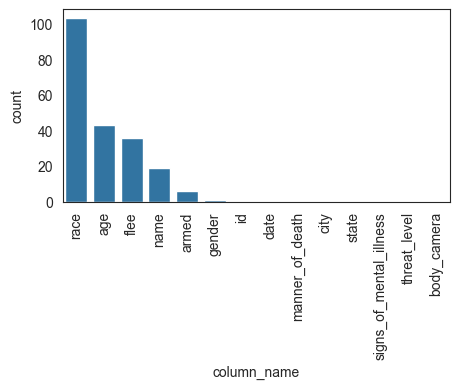

In [257]:
empty_values_df = empty_values.reset_index()
empty_values_df.columns = ["column_name", "count"]
empty_values_df_ordered = empty_values_df.sort_values(
    "count", ascending=False)

plt.figure(figsize=(5, 2.5))
sns.barplot(data=empty_values_df_ordered, 
            x=empty_values_df_ordered["column_name"], 
            y=empty_values_df_ordered["count"])
plt.xticks(rotation=90)          

3. How many rows with empty values?

In [258]:
rows_with_emtpy = db[db.isnull().any(axis=1)]
rows_with_emtpy

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
59,110,William Campbell,2015-01-25,shot,gun,59.0,M,NaN,Winslow,NJ,False,attack,Not fleeing,False
124,584,Alejandro Salazar,2015-02-20,shot,gun,NaN,M,H,Houston,TX,False,attack,Car,False
241,244,John Marcell Allen,2015-03-30,shot,gun,54.0,M,NaN,Boulder City,NV,False,attack,Not fleeing,False
266,534,Mark Smith,2015-04-09,shot and Tasered,vehicle,54.0,M,NaN,Kellyville,OK,False,attack,Other,False
340,433,Joseph Roy,2015-05-07,shot,knife,72.0,M,NaN,Lawrenceville,GA,True,other,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,2345,Mauro Garnica,2017-02-15,shot,unknown weapon,55.0,M,NaN,Newman,CA,False,attack,Not fleeing,False
2125,2373,Kenneth Robertson,2017-02-23,shot,gun,54.0,M,NaN,Fairfax,OK,False,attack,Not fleeing,False
2132,2383,Lorenzo Antoine Cruz,2017-02-25,shot,toy weapon,23.0,M,NaN,Rocklin,CA,False,attack,Foot,False
2133,2384,NaN,2017-02-25,shot,gun,NaN,NaN,NaN,Lumpkin,GA,False,attack,Car,False


In [259]:
number_rows = rows_with_emtpy.shape[0]
number_rows

156

4. What is the percentage of rows containing missing values out of all rows?

In [260]:
db_rows = db.shape[0]
number_rows/db_rows

0.07282913165266107

7% is too much data to delete. Can not simply delete rows containing empty 
values.

5. What is the percentage of missing values in each column?

In [261]:
empty_values_df["%"] = empty_values_df["count"]*100/db_rows
empty_values_df

,column_name,count,%
0,id,0,0.000000
1,name,19,0.887021
2,date,0,0.000000
3,manner_of_death,0,0.000000
4,armed,6,0.280112
5,age,43,2.007470
6,gender,1,0.046685
7,race,103,4.808590
8,city,0,0.000000
9,state,0,0.000000


No column has enough missing values to be removing the whole column.

### 2.1.1 Imputation
Instead of deleting data, we will leave name as it is, replace race with its
own category and impute data for the rest: age, flee, armed, gender.
Visualizing the distribution helped pick which imputation method affects 
the least our data analysis. 
&emsp;Flee, Armed, Gender (categorical): Mode value
&emsp;Age (numeric): Median value
In the end, another visualization was done to ensure imputation's influence 
was minimal.

In [262]:
db_replaced = db.copy()

In [263]:
db_replaced["race"] = db_replaced["race"].fillna("null")

6. How may unique values for *armed*, *age*, *gender*, *flee* ? 

In [264]:
db["armed"].nunique()

64

In [265]:
db["age"].nunique()

71

In [266]:
db["gender"].nunique()

2

In [267]:
db["flee"].nunique()

4

7. How many of each?

In [268]:
db.armed.value_counts()

armed
gun                                 1173
knife                                319
unarmed                              155
vehicle                              136
undetermined                         101
                                    ... 
bean-bag gun                           1
baseball bat and fireplace poker       1
straight edge razor                    1
hand torch                             1
pole and knife                         1
Name: count, Length: 64, dtype: int64

In [269]:
db.age.value_counts()

age
25.0    85
31.0    82
36.0    79
29.0    75
26.0    65
        ..
80.0     1
14.0     1
82.0     1
13.0     1
73.0     1
Name: count, Length: 71, dtype: int64

In [270]:
db.gender.value_counts()

gender
M    2052
F      89
Name: count, dtype: int64

In [271]:
db.flee.value_counts()

flee
Not fleeing    1453
Car             318
Foot            254
Other            81
Name: count, dtype: int64

Visualizing it.

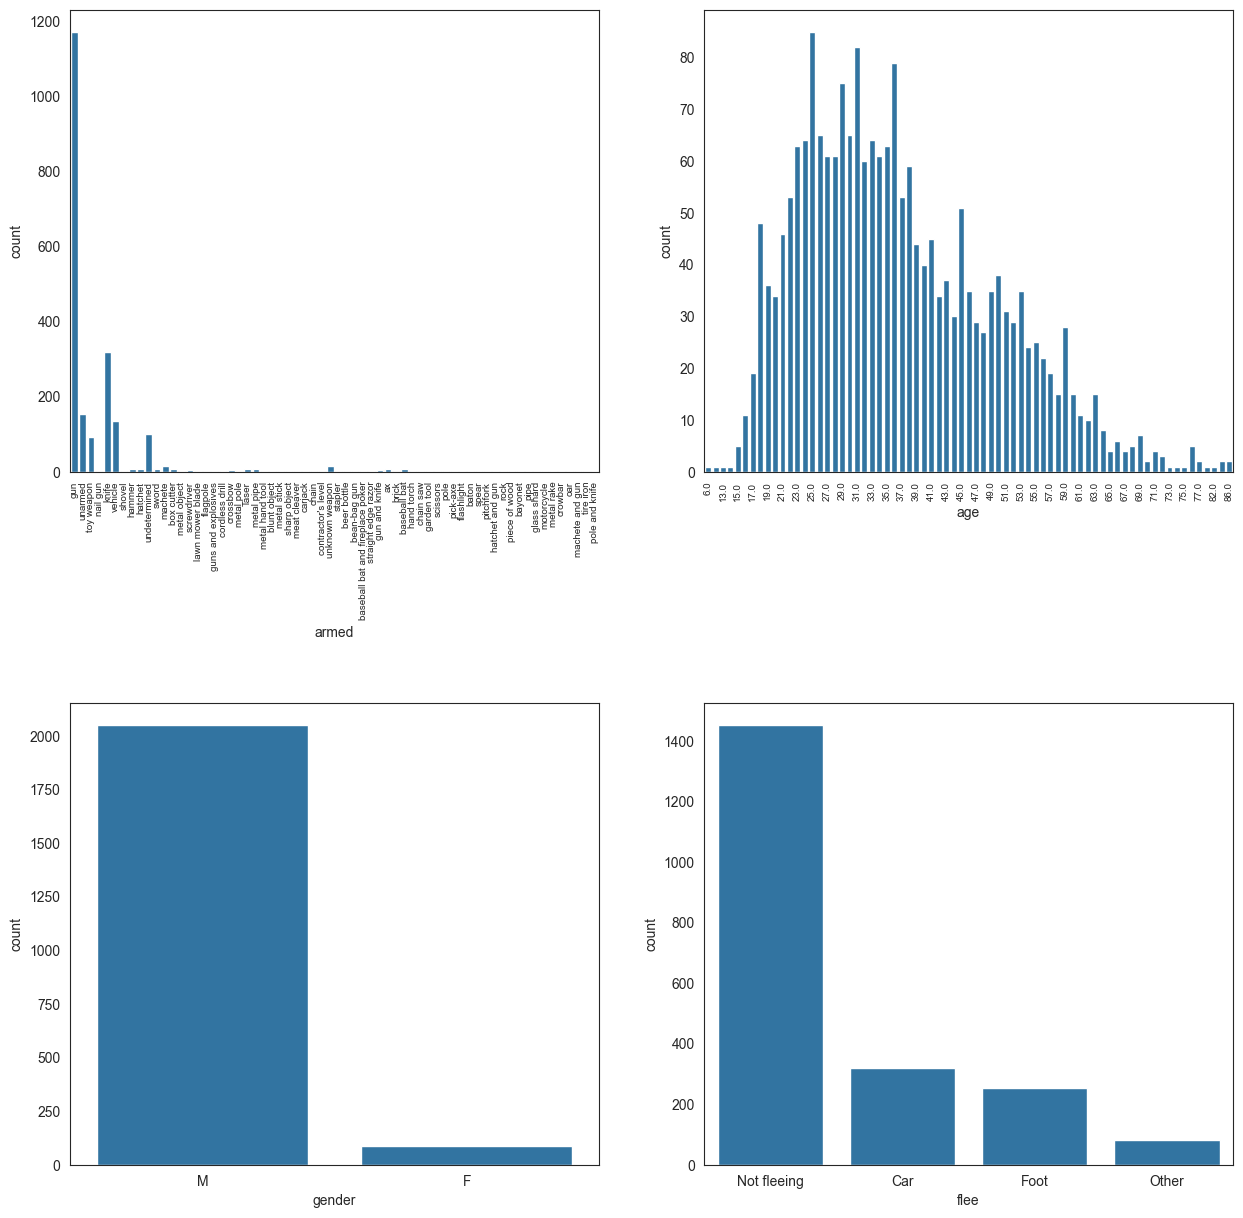

In [272]:
fig = plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=db, x=db["armed"])
plt.xticks(rotation=90, fontsize=7)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=db, x=db["age"])
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune="both", 
                                        nbins=len(db["age"].unique())//2))
plt.xticks(rotation=90, fontsize=7)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=db, x=db["gender"])

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=db, x=db["flee"])

plt.subplots_adjust(hspace=0.5)

**Imputation** 

In [273]:
db_replaced["armed"] = db["armed"].fillna(db["armed"].mode()[0])
db_replaced["gender"] = db["gender"].fillna(db["gender"].mode()[0])
db_replaced["flee"] = db["flee"].fillna(db["flee"].mode()[0])
db_replaced["age"] = db["age"].fillna(db["age"].median())

Visualizing for better comparison to see influence of replaced values.

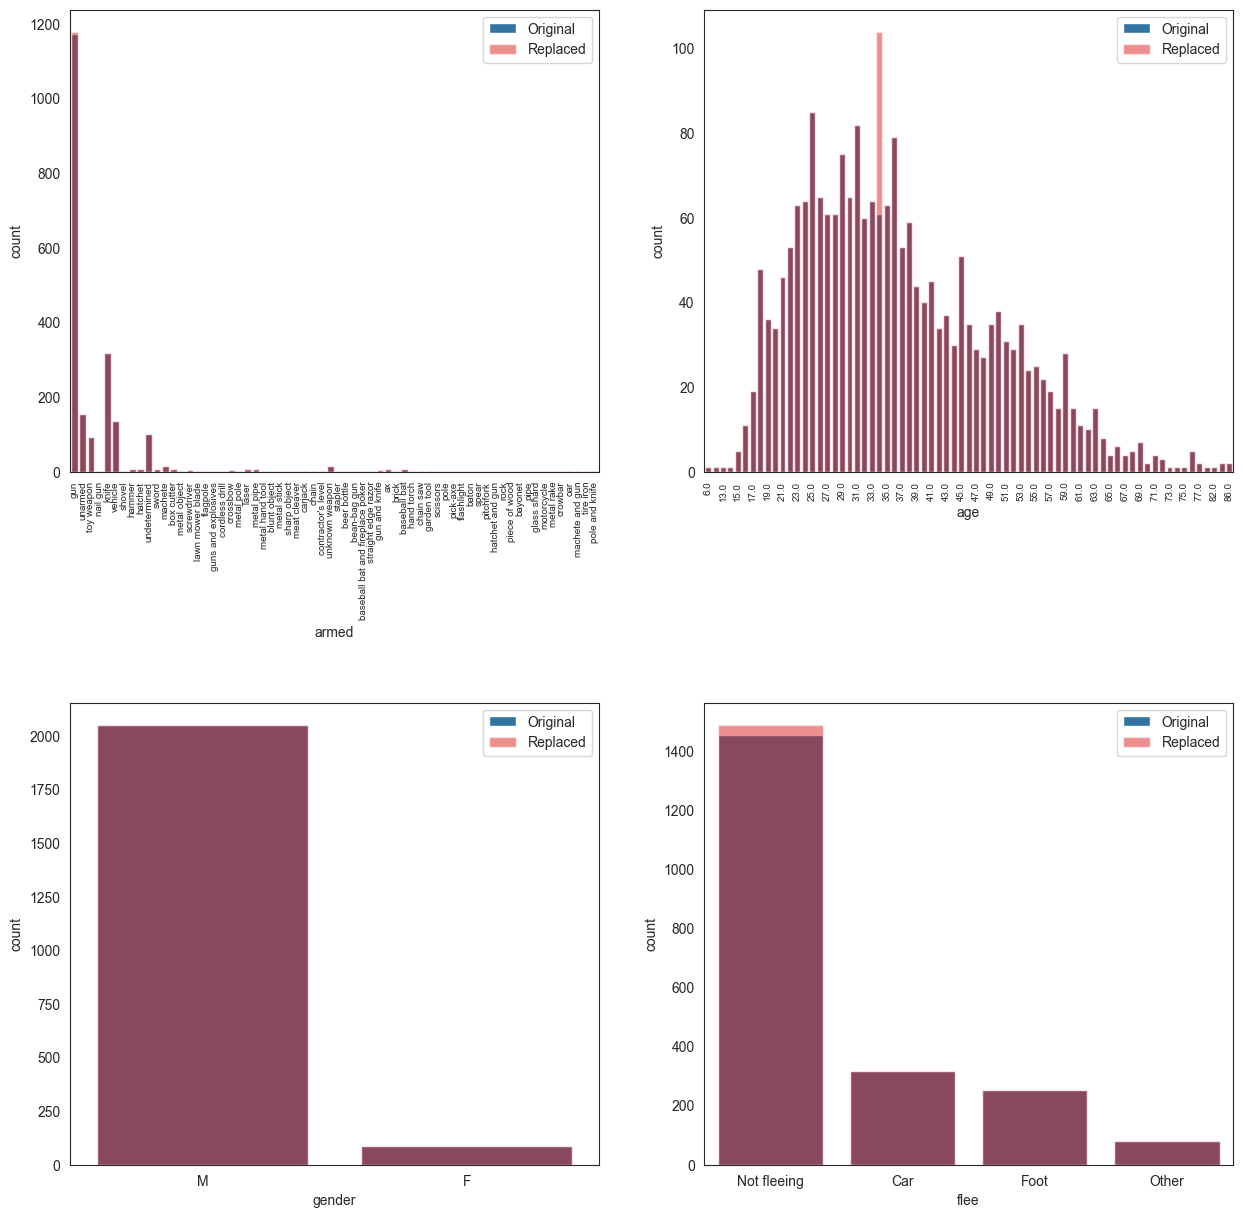

In [274]:
fig = plt.figure(figsize=(15, 15))

ax1 = plt.subplot(2, 2, 1)
sns.countplot(data=db, x=db["armed"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["armed"], color="red", 
              label="Replaced", alpha=0.5)
plt.xticks(rotation=90, fontsize=7)

ax2 = plt.subplot(2, 2, 2)
sns.countplot(data=db, x=db["age"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["age"], color="red", 
              label="Replaced", alpha=0.5)
ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune="both", 
                                        nbins=len(db["age"].unique())//2))
plt.xticks(rotation=90, fontsize=7)

ax3 = plt.subplot(2, 2, 3)
sns.countplot(data=db, x=db["gender"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["gender"], color="red", 
              label="Replaced", alpha=0.5)

ax4 = plt.subplot(2, 2, 4)
sns.countplot(data=db, x=db["flee"], label="Original", alpha=1)
sns.countplot(data=db_replaced, x=db_replaced["flee"], color="red", 
              label= "Replaced", alpha=0.5)

plt.subplots_adjust(hspace=0.5)

8. Did the new values change the data statistics for *age* ?

In [275]:
db["age"].describe()

count    2099.000000
mean       36.484516
std        12.874000
min         6.000000
25%        26.000000
50%        34.000000
75%        45.000000
max        86.000000
Name: age, dtype: float64

In [276]:
db_replaced["age"].describe()

count    2142.000000
mean       36.434641
std        12.748828
min         6.000000
25%        27.000000
50%        34.000000
75%        45.000000
max        86.000000
Name: age, dtype: float64

## 2.2 Duplicates

**Summary: No duplicates in dataset.**

9. Is there any duplicated rows? 

In [277]:
db_replaced.duplicated().any()

False

10. Is there any same case/Id?

In [278]:
db_replaced.id.duplicated().any()

False

## 2.3 Inadequate Datatypes

**Summary: Columns *date* and *age* datatypes are changed to datetime64 and 
int64.**

11. What are the data types of each column? 

In [279]:
db_replaced.dtypes

id                           int64
name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
dtype: object

Age and date datatypes are inadequate.

In [280]:
db_replaced.age = db_replaced.age.astype("int64")

In [281]:
db_replaced["date"] = pd.to_datetime(db_replaced["date"], format="%Y-%m-%d")

In [282]:
db_replaced.dtypes

id                                  int64
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                                 int64
gender                             object
race                               object
city                               object
state                              object
signs_of_mental_illness              bool
threat_level                       object
flee                               object
body_camera                          bool
dtype: object

## 2.4 Outliers/Quick visualization

**Summary: 
Quick visualization of the distribution of deaths through the features. 
This part first focuses on time and age, then state and city, 
at last all the categorical features on one figure with shared axis.
Each part is also followed by data queries and outliers when possible for 
better understanding.**

12. What is the size of our dataset? 

In [283]:
db.shape

(2142, 14)

13. Add a column "armed_simplified" where it considers only 4 categories: 
unarmed, undetermined, gun and other. 

In [284]:
categories_to_keep = ["unarmed", "undetermined", "gun"]

db_replaced["armed_simplified"] = db_replaced["armed"].apply(lambda x: x 
if x.lower() in categories_to_keep else "other")

In [285]:
numeric = ["date", "age"]
categorical = ["manner_of_death", "armed_simplified", "gender", "race", 
               "signs_of_mental_illness", "threat_level", "flee", 
               "body_camera"]
map = ["city", "state"]

### 2.4.1 Death by Time and Age

Time do not seem to have an effect on the number of deaths. It is very even 
overall.
Regarding age, we have a huge range from 6 up to 86 year-olds. Also, 50% of 
fatalities happen between age 27-45.

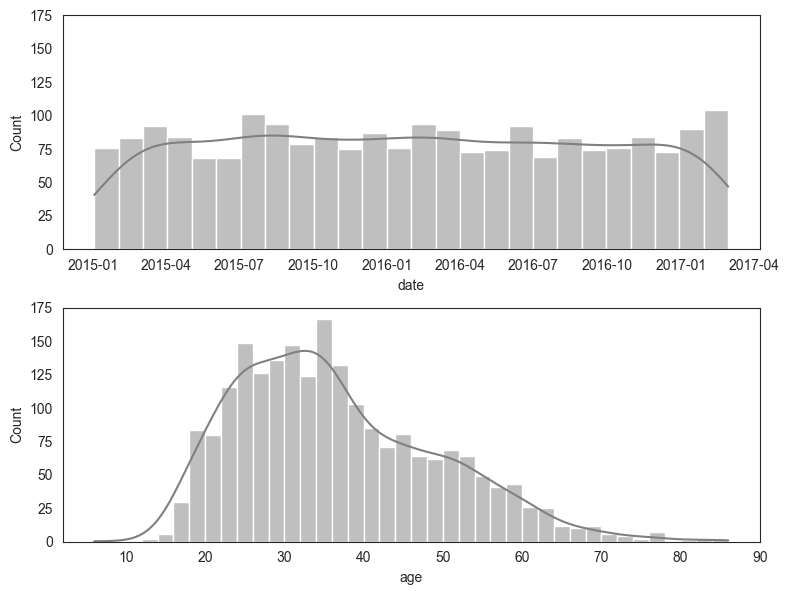

In [286]:
fig, axs = plt.subplots(sharey=True, figsize=(8, 6), nrows=2, ncols=1)
bins_dict = {"age": 40, "date": 26}

for i, feature in enumerate(numeric):
    sns.set_style("whitegrid")
    sns.histplot(data=db_replaced, x=feature, color="grey", 
                 bins=bins_dict[feature], ax=axs[i], kde=True)
    
plt.tight_layout()

14. What month and year had the most and least deaths?

In [287]:
db_replaced["month_year"] = db_replaced["date"].dt.to_period("M")

deaths_month = db_replaced["month_year"].value_counts()
most_deaths_month = deaths_month.idxmax()
most_deaths = deaths_month[most_deaths_month]

least_deaths_month = deaths_month.idxmin()
least_deaths = deaths_month[least_deaths_month]

print(f"Most deaths\n{most_deaths_month}: {most_deaths}")
print(f"Least deaths\n{least_deaths_month}: {least_deaths}")

Most deaths
2015-07: 104
Least deaths
2015-06: 65


15. What is the age range of the fatal shootings? 

In [288]:
min_age = db_replaced.age.min()
max_age = db_replaced.age.max()
max_age-min_age

80

16. Youngest and oldest deaths.

In [289]:
db_replaced[db_replaced.age == min_age]

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,armed_simplified,month_year
830,980,Jeremy Mardis,2015-11-03,shot,unarmed,6,M,W,Marksville,LA,False,other,Car,True,unarmed,2015-11


In [290]:
db_replaced[db_replaced.age == max_age]

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,armed_simplified,month_year
426,542,Raymond Phillips,2015-06-11,shot,gun,86,M,null,Columbia,TN,True,attack,Not fleeing,False,gun,2015-06
1675,1880,Eugene Craig,2016-09-12,shot,gun,86,M,null,Saratoga,CA,False,other,Not fleeing,False,gun,2016-09


**Age Outliers**

<Axes: xlabel='age'>

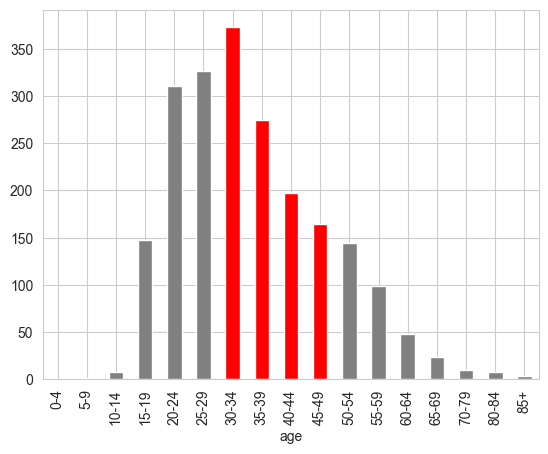

In [291]:
q1 = db_replaced["age"].quantile(0.25)
q3 = db_replaced["age"].quantile(0.75)
iqr = q3-q1

age_bins = list(range(0,90,5))
group_names = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", 
               "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", 
               "65-69", "70-79", "80-84", "85+"]

age_groups = pd.cut(db_replaced["age"], bins=age_bins, labels=group_names)
age_group_counts = age_groups.value_counts().reindex(group_names)
colors = ["red" if q1 <= age <= q3 else "grey" for age in age_bins ]

age_group_counts.plot(kind="bar", color=colors)

In [292]:
print(q1, q3)

27.0 45.0


In [293]:
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
age_outliers = db_replaced[(db_replaced.age<lower_bound) | (db_replaced
                                                   .age>upper_bound)]

age_outliers

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,armed_simplified,month_year
29,52,Talbot Schroeder,2015-01-14,shot,knife,75,M,W,Old Bridge,NJ,False,attack,Not fleeing,False,other,2015-01
92,554,James Allen,2015-02-07,shot,gun,74,M,B,Gastonia,NC,False,attack,Not fleeing,False,gun,2015-02
127,255,Douglas Harris,2015-02-20,shot,gun,77,M,B,Birmingham,AL,True,attack,Not fleeing,False,gun,2015-02
275,357,Richard Dale Weaver,2015-04-12,shot,machete,83,M,W,Oklahoma City,OK,True,other,Not fleeing,False,other,2015-04
315,406,Albert Hanson,2015-04-26,shot,gun,76,M,W,Kings County,CA,False,attack,Not fleeing,False,gun,2015-04
426,542,Raymond Phillips,2015-06-11,shot,gun,86,M,null,Columbia,TN,True,attack,Not fleeing,False,gun,2015-06
518,641,Charles Crandall,2015-07-14,shot,gun,76,M,null,Southington,OH,False,attack,Not fleeing,False,gun,2015-07
598,724,Robert Patrick Quinn,2015-08-09,shot,toy weapon,77,M,null,Pittston,PA,True,attack,Not fleeing,False,other,2015-08
664,797,Charles Robert Shaw,2015-09-01,shot,gun,76,M,W,Twinsburg,OH,False,attack,Not fleeing,False,gun,2015-09
1217,1395,"Ralph ""Phil"" Grenon",2016-03-21,shot and Tasered,knife,76,M,W,Burlington,VT,True,other,Not fleeing,True,other,2016-03


### 2.4.2 Death by State and City
It is obvious that there is a huge incline to certain states. Most cities 
with more fatalities belong to the same 3 states, California, Texas and 
Florida.
Note: These graphs are not normalized to the local population. so we 
still have to eliminate population density being the cause.

17. How many states?

In [294]:
db_replaced.state.nunique()

51

**Death count by State**

In [295]:
statemap_gpd = gpd.read_file("cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

In [296]:
statemap_geojson_with_id = statemap_gpd.set_index(keys="GEOID").to_json()

In [297]:
state_plot_data = db_replaced["state"].value_counts().reset_index()
state_plot_data.columns = ["state", "death_count"]

In [298]:
map = folium.Map(location=[35, -100], zoom_start=3)

folium.Choropleth(geo_data=statemap_geojson_with_id, data=state_plot_data, 
                  name="choropleth", columns=["state", "death_count"], 
                  key_on="feature.properties.STUSPS", fill_color="YlGn", 
                  fill_opacity=0.7, 
                  line_opacity=0.2, legend_name="Death Count").add_to(map)


geojson_layer = folium.GeoJson(
    data=statemap_geojson_with_id,
    name="US States",
    style_function=lambda x: {"fillColor": "transparent", "color": "black", 
                              "weight": 0.5},
    tooltip=GeoJsonTooltip(
        fields=["NAME"],
        aliases=["State: "],
        localize=True,
        sticky=False
    )
).add_to(map)

folium.LayerControl().add_to(map)

map.save("statemap_plot.html")

In [299]:
from IPython.display import HTML
HTML("<iframe src=statemap_plot.html width=700 height=500></iframe>")

D:\ACER\Documents\Data Science\Turing\Capstone Projects\m1_cp\FatalShooting\.venv\lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


**Outlier States**

In [300]:
state_plot_data.head(5)

,state,death_count
0,CA,355
1,TX,197
2,FL,129
3,AZ,95
4,OK,65


In [301]:
q1 = state_plot_data["death_count"].quantile(0.25)
q3 = state_plot_data["death_count"].quantile(0.75)
iqr = q3-q1
lower_bound = q1-1.5*iqr
upper_bound = q3+1.5*iqr
state_outliers = state_plot_data[(state_plot_data["death_count"]<lower_bound) | 
                                 (state_plot_data["death_count"]>upper_bound)]

state_outliers

,state,death_count
0,CA,355
1,TX,197
2,FL,129


**Death count by City**

In [302]:
city_deaths = db_replaced.groupby("city").size()
city_deaths = city_deaths.sort_values(ascending=False)
city_deaths

city
Los Angeles    31
Phoenix        24
Houston        24
Chicago        23
Las Vegas      16
               ..
Highgrove       1
Highland        1
Hiseville       1
Hog Valley      1
Levelland       1
Length: 1247, dtype: int64

### 2.4.3 Death by Categorical Features

Most fatalities cases were male, white, shot, carried guns, didn't show signs
of mental illness, attacked, didn't flee and the police officer didn't carry
body camera.

Note: These graphs are not normalized to population, race population... so we 
still have to eliminate population influence.

18. Replace abbreviations from column "race" with complete words.

In [303]:
race_mapping = {
    "W": "white", 
    "B": "black", 
    "A": "asian", 
    "H": "hispanic", 
    "N": "native", 
    "O": "other"
}

db_replaced.race = db_replaced.race.replace(race_mapping)

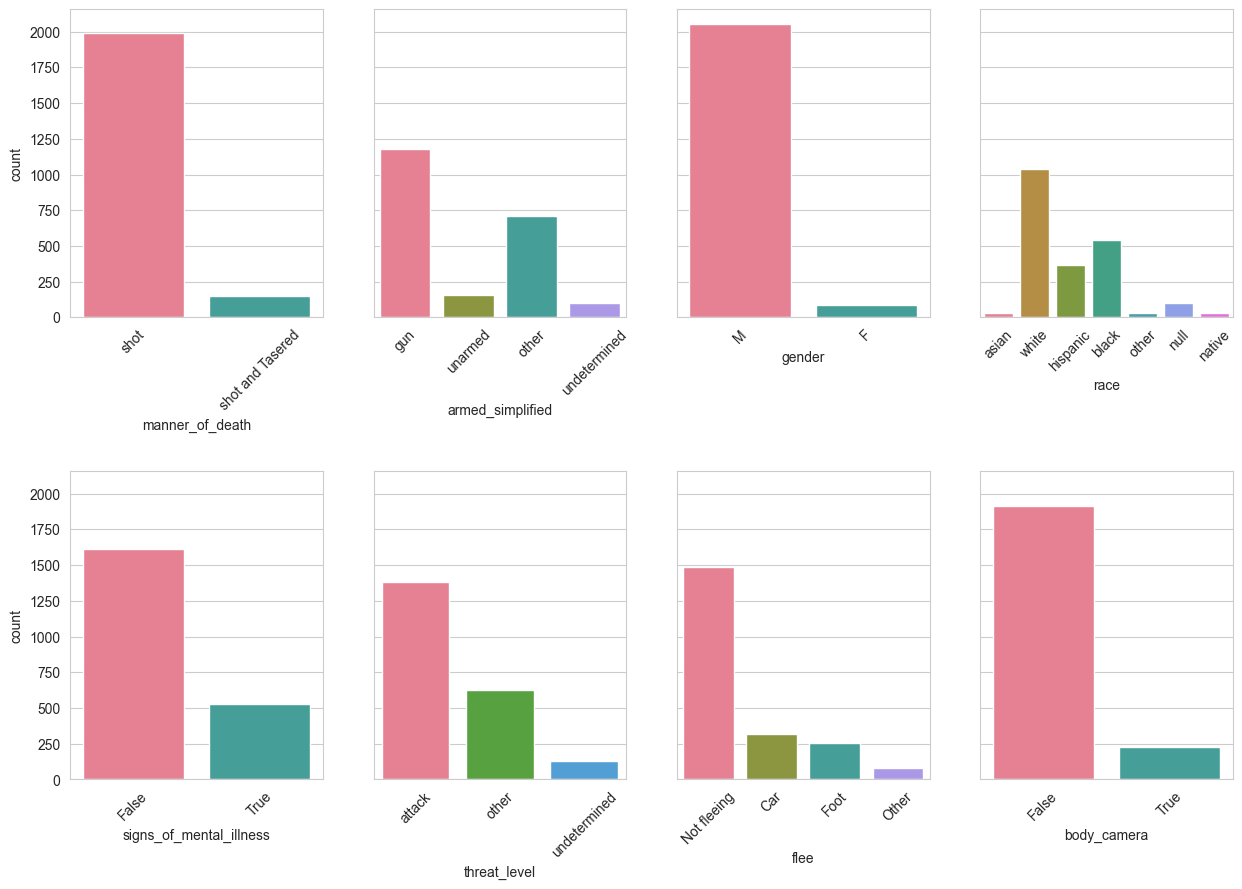

In [304]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=4, sharey=True)
flat_axes = axs.flatten()

for i, feature in enumerate(categorical):
    sns.set_style("whitegrid")
    n_colors = db_replaced[feature].nunique()
    sns.countplot(data=db_replaced, x=feature, hue=feature, ax=flat_axes[i],
                  palette=sns.husl_palette(n_colors), legend=False)
    plt.xlabel(feature)
    flat_axes[i].tick_params(axis='x', rotation=45)

plt.subplots_adjust(hspace=0.5)

# 3.Data Exploration & Visualization

## 3.1 Visualize Deaths Scaled by Racial Proportions

**Summary: From the previous data visualizations, deaths by race was one of 
the graph with an unclear conclusion. It seemed at first glance that most 
fatalities were grouped "white". However, racial population is uneven in the 
US. Therefore, those number do not mean much without proper scaling.**

**After scaling, as the graph shows, the racial group "black" has the highest 
fatality per population (at least 2x more than other groups). While "asian" 
has the lowest.**

1. From https://www.census.gov/quickfacts/fact/table/US#, USA total 
population is 331,449,281 in April 2020. Create a dataframe with its racial
proportion.

In [305]:
us_race = pd.DataFrame([0.589, 0.136, 0.191, 0.016, 0.063], 
                       index=["white", "black", "hispanic", "native", "asian"], 
                       columns=["ratio"])

us_race["population"] = 331449281*us_race["ratio"]

race_df = db_replaced.race.value_counts()
us_race = pd.merge(race_df, us_race, right_index=True, left_index=True)

us_race["scaled_fatalities"] = us_race["count"]/us_race["population"]
us_race = us_race.rename_axis("race")
us_race

,count,ratio,population,scaled_fatalities
race,,,,
white,1041,0.589,1.952236e+08,0.000005
black,542,0.136,4.507710e+07,0.000012
hispanic,367,0.191,6.330681e+07,0.000006
asian,33,0.063,2.088130e+07,0.000002
native,28,0.016,5.303188e+06,0.000005


<Axes: xlabel='race', ylabel='scaled_fatalities'>

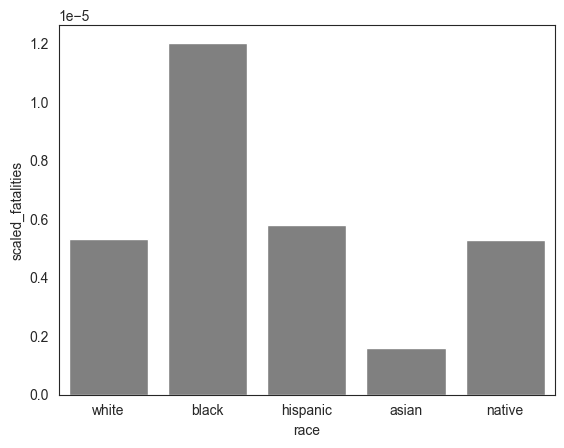

In [306]:
sns.set_style("white")
sns.barplot(data=us_race, x="race" ,y="scaled_fatalities", color="grey")

After scaling, it is shown that the racial group "black" have roughly 2x as 
many fatalities compared to "white", "hispanic" and "native". And 6x as many
 when compared to "asian".

## 3.2 Extra Dataset - Population by State & by Race

**Summary: Introduce new dataset from Census 2020 about population and racial 
population in each state in 2020, called *p5*.
With the new *p5* data, like in 3.1 we are able to scale the police shooting 
fatalities to the population.
The original data was grouped into state and race. In order to scale the 
number of fatal police shooting cases, the grouped data was then divided by 
the population information gathered from *p5*.**

**From the scaled data, fatality per million, it is understood that the states
with the highest fatality rates are New Mexico, Oklahoma, Alaska, District 
of Columbia and West Virginia. This is, however, not consistent when race is 
analyzed separately.**

### 3.2.1 Introduce new dataset & Quick Cleaning

In [307]:
p5 = pd.read_csv("census2020_P5.csv")

2. Remove unnecessary columns.

In [308]:
p5 = p5.drop(index=[7, 8, 10, 11, 12, 13, 14, 15 ,16])

3. States in the rows and add index to number them.

In [309]:
p5 = p5.T.reset_index()

4. Match the header to our dataset in analysis and add new index numbering the 
rows.

In [310]:
new_header = ["state", "total", "not hispanic", "white", "black", "native1",
              "asian", "native2", "hispanic" ]
p5 = p5.iloc[1:]
p5.columns = new_header
p5 = p5.reset_index(drop=True)
p5.head(5)

,state,total,not hispanic,white,black,native1,asian,native2,hispanic
0,Alabama,"5,024,279","4,760,232","3,171,351","1,288,159","23,119","75,918","2,612","264,047"
1,Alaska,"733,391","683,567","421,758","20,731","108,838","43,449","12,455","49,824"
2,Arizona,"7,151,502","4,959,249","3,816,547","317,161","263,930","248,837","14,323","2,192,253"
3,Arkansas,"3,011,524","2,754,677","2,063,550","449,884","20,549","51,210","14,280","256,847"
4,California,"39,538,223","23,958,571","13,714,587","2,119,286","156,085","5,978,795","138,167","15,579,652"


5. Remove Puerto Rico.

In [311]:
p5 = p5.drop(index=51)

6. Make sure data type is numeric for the population columns.

In [312]:
p5.dtypes

state           object
total           object
not hispanic    object
white           object
black           object
native1         object
asian           object
native2         object
hispanic        object
dtype: object

In [313]:
for col in p5.columns[1:]:
    p5[col] = p5[col].replace(",", "", regex=True).astype("int64")
p5.dtypes

state           object
total            int64
not hispanic     int64
white            int64
black            int64
native1          int64
asian            int64
native2          int64
hispanic         int64
dtype: object

7. Consider "native1" and "native2" as one category only.

In [314]:
p5["native"] = p5[["native1", "native2"]].sum(axis=1)
p5 = p5.drop(columns=["native1", "native2"])
p5 = p5.sort_values(by="state").reset_index(drop=True)

8. Is there any empty data?

In [315]:
p5.isnull().any().any()

False

9. Is there duplicates?

In [316]:
p5.duplicated().any()

False

### 3.2.2 Scale Fatalities to Population & Quick exploration

10. Create a new dataframe containing the number of police shooting 
fatalities of each state and also the number for each race within these 
states. Make sure the datatype is numeric.

In [317]:
grouped = (db_replaced.groupby(by=["state", "race"]).size().reset_index
           (name="count"))
pivot = pd.pivot_table(grouped, values="count", index="state", 
                       columns="race", fill_value=0)
pivot["total"] = pivot.sum(axis=1)
pivot = pivot.reset_index()

for col in pivot.columns[1:]:
    pivot[col] = pivot[col].astype("int64")

pivot.head(5)

race,state,asian,black,hispanic,native,null,other,white,total
0,AK,0,1,0,5,1,0,5,12
1,AL,0,12,0,0,2,0,30,44
2,AR,0,3,0,0,4,0,14,21
3,AZ,0,4,30,8,5,0,48,95
4,CA,14,60,145,0,25,8,103,355


11. Match the name and order of the states to our dataset *p5* so it can be 
operated together later.

In [318]:
state_mapping = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AS": "American Samoa",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "DC": "District of Columbia",
    "FM": "Federated States Of Micronesia",
    "FL": "Florida",
    "GA": "Georgia",
    "GU": "Guam",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MH": "Marshall Islands",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "MP": "Northern Mariana Islands",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PW": "Palau",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VI": "Virgin Islands",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

pivot.state = pivot.state.replace(state_mapping)
pivot = (pivot.sort_values(by="state").reset_index
                   (drop=True))
pivot.head(5)

race,state,asian,black,hispanic,native,null,other,white,total
0,Alabama,0,12,0,0,2,0,30,44
1,Alaska,0,1,0,5,1,0,5,12
2,Arizona,0,4,30,8,5,0,48,95
3,Arkansas,0,3,0,0,4,0,14,21
4,California,14,60,145,0,25,8,103,355


12. Scale the fatalities by our dataset *p5* and limit the decimals.

In [319]:
p5 = p5.set_index("state")
pivot = pivot.set_index("state")
common_columns = p5.columns.intersection(pivot.columns)
shootings_scaled_by_population = pivot[common_columns].div(p5[common_columns])
shootings_scaled_by_population = shootings_scaled_by_population.reset_index()
shootings_scaled_by_population.iloc[:, 1:] = shootings_scaled_by_population.iloc[:, 1:]*1000000
shootings_scaled_by_population = shootings_scaled_by_population.round(2)

shootings_scaled_by_population.head(5)

race,state,total,white,black,asian,hispanic,native
0,Alabama,8.76,9.46,9.32,0.00,0.00,0.00
1,Alaska,16.36,11.86,48.24,0.00,0.00,41.22
2,Arizona,13.28,12.58,12.61,0.00,13.68,28.75
3,Arkansas,6.97,6.78,6.67,0.00,0.00,0.00
4,California,8.98,7.51,28.31,2.34,9.31,0.00


13. After scaling, which are the top 5 states with the highest fatalities 
for each race.

In [320]:
top5_by_column = {}

for column in shootings_scaled_by_population.columns[1:]:
    top5_by_column[column] = (shootings_scaled_by_population
                              .sort_values(by=column, ascending=False)
                              .head(5))
top5_by_column["total"]

race,state,total,white,black,asian,hispanic,native
31,New Mexico,20.78,19.41,0.00,0.0,25.72,5.26
36,Oklahoma,16.42,16.20,49.43,0.0,8.48,3.12
1,Alaska,16.36,11.86,48.24,0.0,0.00,41.22
8,District of Columbia,14.50,0.00,35.45,0.0,0.00,0.00
48,West Virginia,13.94,11.88,46.33,0.0,0.00,0.00


In [321]:
top5_by_column["white"]

race,state,total,white,black,asian,hispanic,native
31,New Mexico,20.78,19.41,0.00,0.0,25.72,5.26
36,Oklahoma,16.42,16.20,49.43,0.0,8.48,3.12
2,Arizona,13.28,12.58,12.61,0.0,13.68,28.75
48,West Virginia,13.94,11.88,46.33,0.0,0.00,0.00
1,Alaska,16.36,11.86,48.24,0.0,0.00,41.22


In [322]:
top5_by_column["black"]

race,state,total,white,black,asian,hispanic,native
36,Oklahoma,16.42,16.20,49.43,0.00,8.48,3.12
1,Alaska,16.36,11.86,48.24,0.00,0.00,41.22
48,West Virginia,13.94,11.88,46.33,0.00,0.00,0.00
11,Hawaii,6.87,0.00,45.71,3.76,0.00,0.00
19,Maine,5.87,4.07,39.82,0.00,0.00,0.00


In [323]:
top5_by_column["asian"]

race,state,total,white,black,asian,hispanic,native
18,Louisiana,10.31,6.93,18.59,11.72,0.00,0.00
5,Colorado,11.08,7.45,36.15,10.24,15.83,23.38
42,Tennessee,6.95,6.53,8.30,7.45,4.17,0.00
35,Ohio,5.34,3.46,17.84,6.74,0.00,0.00
11,Hawaii,6.87,0.00,45.71,3.76,0.00,0.00


In [324]:
top5_by_column["hispanic"]

race,state,total,white,black,asian,hispanic,native
31,New Mexico,20.78,19.41,0.00,0.00,25.72,5.26
50,Wyoming,13.87,10.65,0.00,0.00,16.94,81.50
12,Idaho,7.61,6.89,0.00,0.00,16.71,0.00
5,Colorado,11.08,7.45,36.15,10.24,15.83,23.38
2,Arizona,13.28,12.58,12.61,0.00,13.68,28.75


In [325]:
top5_by_column["native"]

race,state,total,white,black,asian,hispanic,native
45,Vermont,4.67,3.49,0.00,0.0,0.00,463.82
50,Wyoming,13.87,10.65,0.00,0.0,16.94,81.50
34,North Dakota,3.85,1.57,0.00,0.0,0.00,52.33
1,Alaska,16.36,11.86,48.24,0.0,0.00,41.22
2,Arizona,13.28,12.58,12.61,0.0,13.68,28.75


14. Which are the top 5 states with the lowest fatalities for each race.

In [326]:
last5 = (shootings_scaled_by_population.sort_values(by="total", 
                                                    ascending=True).head(5))
last5

race,state,total,white,black,asian,hispanic,native
39,Rhode Island,1.82,0.00,18.06,0.00,5.49,0.0
6,Connecticut,1.94,2.19,0.00,0.00,1.60,0.0
32,New York,2.03,1.51,7.25,0.52,0.76,0.0
21,Massachusetts,2.99,1.90,15.32,0.00,5.63,0.0
22,Michigan,3.08,2.47,8.83,0.00,1.77,0.0


15. Range of fatality rate for each race.

In [327]:
fatality_range = pd.DataFrame(index=shootings_scaled_by_population
                              .columns[1:], columns=["range"])

for column in shootings_scaled_by_population.columns[1:]:
    max_value = shootings_scaled_by_population[column].max()
    min_value = shootings_scaled_by_population[column].min()
    fatality_range.loc[column, "range"] = max_value - min_value

fatality_range

,range
race,
total,18.96
white,19.41
black,49.43
asian,11.72
hispanic,25.72
native,463.82


<Axes: xlabel='race', ylabel='range'>

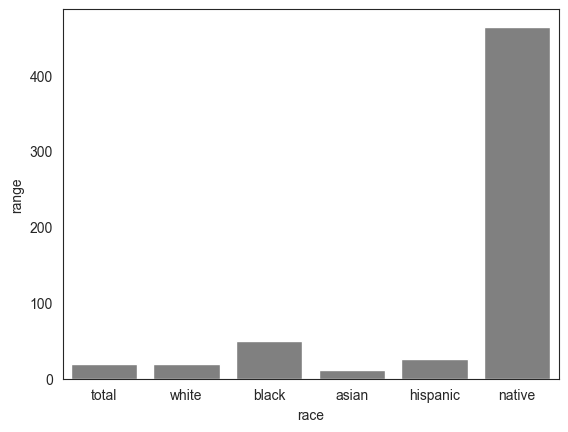

In [328]:
sns.barplot(data=fatality_range, x=fatality_range.index, 
            y=fatality_range.range, color="grey")

### 3.2.3 Visualize Scaled Fatalities (state & race)

**Function to create maps without repetition**

In [329]:
def add_choropleth(map, geo_data, data, column, layer_name):
    folium.Choropleth(
        geo_data=geo_data,
        data=data,
        name=f"Deaths - {layer_name}",
        columns=["state", column],
        key_on="feature.properties.NAME",
        fill_color="YlGn",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=f"Deaths per million- {layer_name}"
    ).add_to(map)

**Add US States layer with tooltips**

In [330]:
def add_states(map):
    folium.GeoJson(
        data = statemap_geojson_with_id,
        name="US States",
        style_function=lambda x: {"fillColor": "transparent", "color": "black",
                               "weight": 0.5},
        tooltip=folium.GeoJsonTooltip(
        fields=["NAME"],
        aliases=["State:"],
        localize=True,
        sticky=False
        )
    ).add_to(map)

In [331]:
map = folium.Map(location=[35, -100], zoom_start=3)

data = shootings_scaled_by_population

geo_data = statemap_geojson_with_id

demographics = ["total", "white", "black", "asian", "hispanic", "native"]
for demo in demographics:
    add_choropleth(map, geo_data, data, demo, demo.capitalize())

add_states(map)

folium.LayerControl().add_to(map)

map.save("scaled_deaths_by_race.html")

In [332]:
from IPython.display import HTML
HTML("<iframe src=scaled_deaths_by_race.html width=1000 height=600></iframe>")

D:\ACER\Documents\Data Science\Turing\Capstone Projects\m1_cp\FatalShooting\.venv\lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# 4. Correlation Analysis

Race inequality - Black and Natives(in very specific states)
Why certain states have higher fatalities rate?

## 4.1 Race inequality - Native racial group with unusually high fatality 
## rate in Vermont

**Summary: Hypothesis, native american is a relatively small racial 
group, so the fatality rate can be falsely high specially in states with an 
even smaller group of native americans.
There is no significant Pearson correlation between population and fatality 
rate.**


In [333]:
pivot

race,asian,black,hispanic,native,null,other,white,total
state,,,,,,,,
Alabama,0,12,0,0,2,0,30,44
Alaska,0,1,0,5,1,0,5,12
Arizona,0,4,30,8,5,0,48,95
Arkansas,0,3,0,0,4,0,14,21
California,14,60,145,0,25,8,103,355
Colorado,2,8,20,1,5,0,28,64
Connecticut,0,0,1,0,1,0,5,7
Delaware,0,1,0,0,0,0,4,5
District of Columbia,0,10,0,0,0,0,0,10


In [334]:
shootings_scaled_by_population

race,state,total,white,black,asian,hispanic,native
0,Alabama,8.76,9.46,9.32,0.00,0.00,0.00
1,Alaska,16.36,11.86,48.24,0.00,0.00,41.22
2,Arizona,13.28,12.58,12.61,0.00,13.68,28.75
3,Arkansas,6.97,6.78,6.67,0.00,0.00,0.00
4,California,8.98,7.51,28.31,2.34,9.31,0.00
5,Colorado,11.08,7.45,36.15,10.24,15.83,23.38
6,Connecticut,1.94,2.19,0.00,0.00,1.60,0.00
7,Delaware,5.05,6.90,4.70,0.00,0.00,0.00
8,District of Columbia,14.50,0.00,35.45,0.00,0.00,0.00
9,Florida,5.99,5.50,14.07,1.59,2.81,0.00


In [335]:
p5

,total,not hispanic,white,black,asian,hispanic,native
state,,,,,,,
Alabama,5024279,4760232,3171351,1288159,75918,264047,25731
Alaska,733391,683567,421758,20731,43449,49824,121293
Arizona,7151502,4959249,3816547,317161,248837,2192253,278253
Arkansas,3011524,2754677,2063550,449884,51210,256847,34829
California,39538223,23958571,13714587,2119286,5978795,15579652,294252
Colorado,5773714,4510324,3760663,221310,195220,1263390,42773
Connecticut,3605944,2982651,2279232,360937,170459,623293,7378
Delaware,989948,885658,579851,212960,42398,104290,2825
District of Columbia,689545,611893,261771,282066,33192,77652,1626


In [336]:
shootings_scaled_by_population = shootings_scaled_by_population.set_index("state")

In [338]:
merged_native = pd.merge(p5["native"], pivot["native"], left_index=True, 
                         right_index=True)
merged_native = pd.merge(merged_native, shootings_scaled_by_population["native"], 
                         left_index=True, right_index=True)
merged_native.columns = ["population", "fatalities", "fatalities_per_million"]
merged_native.head()

,population,fatalities,fatalities_per_million
state,,,
Alabama,25731,0,0.00
Alaska,121293,5,41.22
Arizona,278253,8,28.75
Arkansas,34829,0,0.00
California,294252,0,0.00
Colorado,42773,1,23.38
Connecticut,7378,0,0.00
Delaware,2825,0,0.00
District of Columbia,1626,0,0.00


**SPLOM scatter plot matrix**

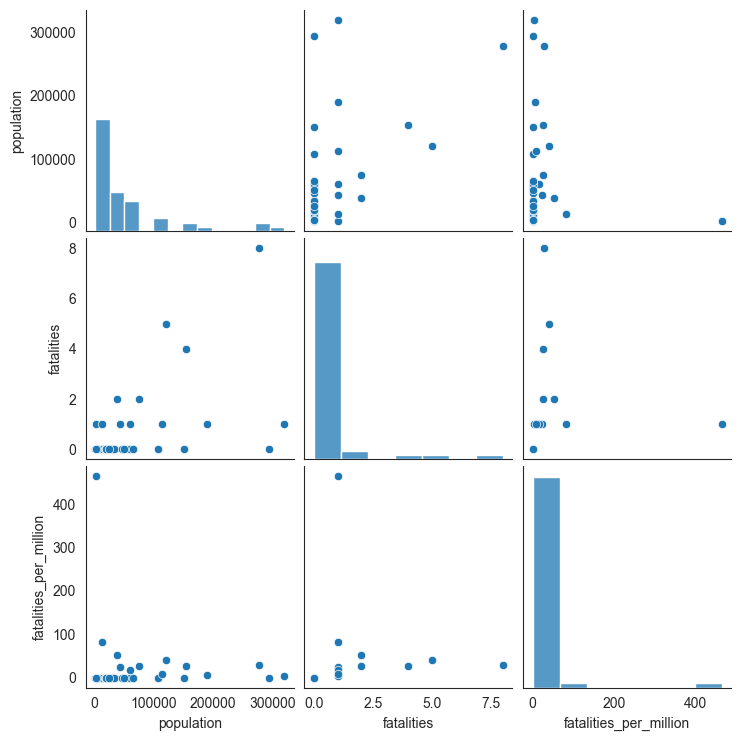

In [343]:
sns.pairplot(merged_native)

### 4.1.1 Correlation Check - Pearson

In [339]:
merged_native.corr()

,population,fatalities,fatalities_per_million
population,1.000000,0.528963,-0.064704
fatalities,0.528963,1.000000,0.183188
fatalities_per_million,-0.064704,0.183188,1.000000


### 4.1.2 Correlation Check - Pearson (without the state with highest 
### fatality rate)

In [348]:
merged_native_without_outlier = merged_native.drop(index="Vermont")

In [350]:
merged_native_without_outlier.corr()

,population,fatalities,fatalities_per_million
population,1.000000,0.537077,0.155442
fatalities,0.537077,1.000000,0.589826
fatalities_per_million,0.155442,0.589826,1.000000


## 4.2 Race inequality - Is it actually different between race?

In [ ]:
""""grouped_data = db_replaced.groupby('race').agg(
    total_cases=pd.NamedAgg(column='age', aggfunc='count'),
    mental_illness_cases=pd.NamedAgg(column='signs_of_mental_illness', aggfunc='sum'),
    cases_with_guns=pd.NamedAgg(column='armed', aggfunc=lambda x: (x == 'gun').sum())
)
grouped_data""""

# Improvements

1. Methodology differences may exist between data sources, and so may not be
 comparable.
2. New datasets are data from Census 2020, not from years 2015-2017, which 
may affect analysis. Also, COVID-19 may have an impact on the data.